In [1]:
# Magic line to force reload all modules when this cell is run multiple times
%load_ext autoreload
%autoreload 2

from ClusterPipeline import ClusterPipeline
from helper import plot_confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import pandas as pd
import umap

/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
import plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot
from plotly.offline import plot
import ipywidgets as widgets

# %matplotlib widget
py.offline.init_notebook_mode(connected=True)

In [3]:
# a=[(1,2,3)]
# [x for x in (*a[0],4)]
# (*a[0],4)

In [4]:
def get_split_index(features, labels, test_size=0.1):
    import numpy as np
    from sklearn.model_selection import StratifiedShuffleSplit
    
    features = np.array(features)
    # The train set will have equal amounts of each target class
    # Performing single split
    split = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=42)
    return [[train_index, test_index] for train_index,test_index in split.split(features, labels)]

def split_valid(features, training_labels, valid_size=0.5):
    train_index, validation_index = get_split_index(features, training_labels, test_size=valid_size)[0]
    X_valid, y_valid = features.iloc[validation_index], training_labels.iloc[validation_index]
    X_train, y_train = features.iloc[train_index], training_labels.iloc[train_index]
     
    return X_train, y_train, X_valid, y_valid

In [5]:
raw_data = pd.read_csv("data/original_heart.csv").astype(np.float64)

original_data = raw_data.drop(columns=["oldpeak", "target"]).astype(np.int64)
original_data["oldpeak"] = raw_data["oldpeak"] # To keep it as a float
original_data = pd.get_dummies(original_data, 
                               columns=["cp","restecg","thal"],
                               prefix=["cp","restecg","thal"])
original_labels = raw_data["target"].astype(np.int64)

training_labels = raw_data["target"].astype(np.int64)
training_labels[training_labels > 0] = 1

print("Original Distribution:\n",original_labels.value_counts(), sep="")
print("Combined:\n",training_labels.value_counts(), sep="")

original_data.head()

Original Distribution:
0    160
1     54
3     35
2     35
4     13
Name: target, dtype: int64
Combined:
0    160
1    137
Name: target, dtype: int64


,age,sex,trestbps,chol,fbs,thalach,exang,slope,ca,oldpeak,cp_1,cp_2,cp_3,cp_4,restecg_0,restecg_1,restecg_2,thal_3,thal_6,thal_7
0,63,1,145,233,1,150,0,3,0,2.3,1,0,0,0,0,0,1,0,1,0
1,67,1,160,286,0,108,1,2,3,1.5,0,0,0,1,0,0,1,1,0,0
2,67,1,120,229,0,129,1,2,2,2.6,0,0,0,1,0,0,1,0,0,1
3,37,1,130,250,0,187,0,3,0,3.5,0,0,1,0,1,0,0,1,0,0
4,41,0,130,204,0,172,0,1,0,1.4,0,1,0,0,0,0,1,1,0,0


In [6]:
cleveland_data = pd.read_csv("data/heart.csv")
cleveland_data["target"].value_counts()
    
# original_data = raw_data.drop(columns=["target"])
# training_labels = raw_data["target"]
# raw_data.head()
# cleveland_data.dtypes

1    165
0    138
Name: target, dtype: int64

In [7]:
def exp_decay(epoch):
    initial_lr = 0.1
    decay_steps = 50
    decay_rate = 0.1
    
    decayed_lr =  initial_lr * np.power(decay_rate, (epoch/decay_steps))
#     print("New Learning Rate:", decayed_lr)
    return decayed_lr

def build_dnn(num_features, num_nodes = 16, depth = 2, num_labels=2, activation = "elu"):
    
    import tensorflow as tf
    import keras
    from keras import optimizers
    from keras import regularizers
    keras.backend.clear_session()
    
    reg_scale = 0.001 # For L1 Reg
    my_reg = regularizers.l1(reg_scale) # Can change this if needed
    
    dnn = keras.models.Sequential()

    Dense = keras.layers.Dense

    # Using He initialization
    he_init = keras.initializers.he_normal()
    

    dnn.add(Dense(units = 25, activation="elu", input_dim=num_features,
                  kernel_initializer=he_init, kernel_regularizer = my_reg))
    dnn.add(keras.layers.Dropout(0.5))
#     dnn.add(Dense(units = 15, activation="elu",
#                   kernel_initializer=he_init, kernel_regularizer = my_reg))
#     dnn.add(keras.layers.Dropout(0.5))
    dnn.add(Dense(units=25, activation='elu',
                  kernel_initializer=he_init, kernel_regularizer = my_reg))
    dnn.add(keras.layers.Dropout(0.5))
    
    dnn.add(Dense(units=num_labels, activation="softmax",
                  kernel_initializer=he_init, kernel_regularizer = my_reg)) # 5 labels -> logits for now
    
#     nadam = keras.optimizers.Nadam()
    NSGD = keras.optimizers.SGD(lr=0.01,momentum=0.9,nesterov=True)
    
    dnn.compile(loss='categorical_crossentropy',
                  optimizer=NSGD,
                  metrics=['accuracy'])
    
    return dnn

In [8]:
## Need to define a scaling function that ignores categorical values...?

In [9]:
nn = build_dnn(num_features=original_data.shape[1])
nn.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 25)                525       
_________________________________________________________________
dropout_1 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 25)                650       
_________________________________________________________________
dropout_2 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 52        
Total params: 1,227
Trainable params: 1,227
Non-trainable params: 0
___________________

Using TensorFlow backend.


In [10]:
reducer = umap.UMAP(random_state=42,
                    n_components = 10,
                    n_neighbors=15,
                    min_dist=0)

In [11]:
# Separating a hold out set that will be used for validation later
X_train, y_train_orig, X_valid, y_valid_orig = split_valid(original_data, original_labels, valid_size=0.1)

y_train = training_labels[y_train_orig.index]
y_valid = training_labels[y_valid_orig.index]



In [12]:
pipeline = ClusterPipeline(nn, [X_train, y_train], [X_valid,y_valid], target_class=1, reducer=reducer)

# def modKFold(n_splits, self=pipeline):
#     from sklearn.model_selection import StratifiedKFold as KFold
#     kf = KFold(n_splits=n_splits, shuffle=True, random_state=42 ) #Default = 10
#     print("Running modified kfold...")
#     X = self.train_set.features
#     y = y_train_orig

#     for train_index, test_index in kf.split(X,y):
#         yield train_index, test_index

# pipeline.getKFold = modKFold 
pipeline.train_model(batch_size=20,epochs=100, cross_validation=True, parallel=False, verbose=0)

Running Serial Crossvalidation
Running worker: 0
Instructions for updating:
Use tf.cast instead.
Fold: 0 -> Loss:0.402, Acc:0.8915
Prediction Accuracy
28/28 [==============================] - 0s 1ms/step
Scores on data set: loss=0.783 accuracy=0.8571
Fold Correct: 24
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Running worker: 1
Fold: 1 -> Loss:0.498, Acc:0.8721
Prediction Accuracy
28/28 [==============================] - 0s 14us/step
Scores on data set: loss=0.539 accuracy=0.8929
Fold Correct: 25
Running worker: 2
Fold: 2 -> Loss:0.473, Acc:0.8876
Prediction Accuracy
28/28 [==============================] - 0s 13us/step
Scores on data set: loss=0.441 accuracy=0.8929
Fold Correct: 25
Running worker: 3
Fold: 3 -> Loss:0.467, Acc:0.8837
Prediction Accuracy
27/27 [==============================] - 0s 18us/step
Scores on data set: loss=0.512 accuracy=0.8519
Fold Correct: 23
Running worker: 4
Fold: 4 -> Loss:0.452, Acc:0.9000
Prediction Accuracy
26/26 [=====

Confusion matrix, without normalization
[[0.875      0.125     ]
 [0.19512195 0.80487805]]
Overall Accuracy: 0.8427


(<matplotlib.axes._subplots.AxesSubplot at 0x1a2ea52358>, array([[126,  18],
        [ 24,  99]]))

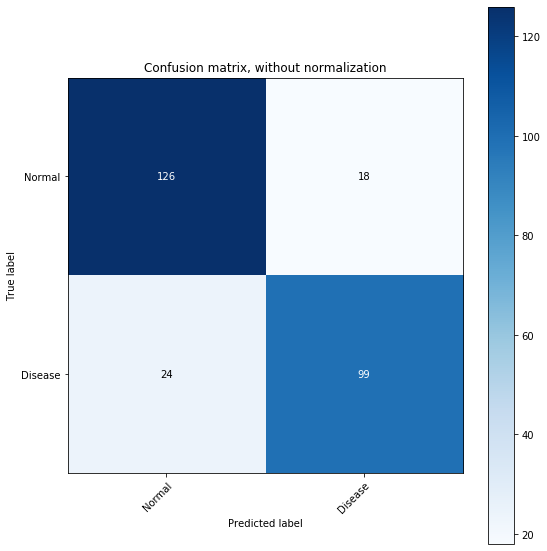

In [13]:
plot_confusion_matrix(y_train.values[pipeline.testing_idxs], np.array(pipeline.predictions, dtype=int), np.array(["Normal", "Disease"]))

In [14]:
# correct_pred_labels = pipeline.val.labels.iloc[self.testing_idxs][self.correct_preds_bool_arr]
# split_class = correct_pred_labels == class_label
# split_class_lrp = np.array(self.lrp_results)[split_class]

# self.training_lrp = np.clip(split_class_lrp, 0,None)
# labels = correct_pred_labels[split_class]

# self.reducer_pipeline = self.reducer_pipeline.fit(self.training_lrp)
# embeddings = self.reducer_pipeline.transform(self.training_lrp)

# if not min_cluster_sizes:
#     n_neighbours = self.reducer_pipeline["umap"].n_neighbors
#     min_cluster_sizes = range(n_neighbours-3, n_neighbours+3)

# scores = self.clusterPerf(embeddings, labels, min_cluster_sizes, plot)
# print("Minimum Size:")
# print(scores.idxmin())

# minsize, minsamp = scores["Halkidi-Filtered Noise"].idxmin()
# self.clusterer = hdbscan.HDBSCAN(min_cluster_size=minsize, min_samples=minsamp, prediction_data=True)
# self.clusterer.fit(embeddings)


In [15]:
min_cluster_sizes=range(5,10,1)
pipeline.train_clusterer(min_cluster_sizes=min_cluster_sizes, plot=False)

/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/umap/umap_.py:349: NumbaWarning:


Compilation is falling back to object mode WITH looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'nearest_neighbors': cannot determine Numba type of <class 'function'>

File "../../anaconda3/envs/condatensor/lib/python3.6/site-packages/umap/umap_.py", line 467:
def fuzzy_simplicial_set(
    <source elided>
    if knn_indices is None or knn_dists is None:
        knn_indices, knn_dists, _ = nearest_neighbors(
        ^


/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/numba/compiler.py:742: NumbaWarning:

Function "fuzzy_simplicial_set" was compiled in object mode without forceobj=True.

File "../../anaconda3/envs/condatensor/lib/python3.6/site-packages/umap/umap_.py", line 350:
@numba.jit()
def fuzzy_simplicial_set(
^


/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/numba/compiler.py:751

Minimum Size:
Clusters                  (5, 5)
Noise                     (5, 5)
Halkidi                   (5, 5)
Halkidi-Filtered Noise    (9, 9)
dtype: object


(        Clusters     Noise   Halkidi  Halkidi-Filtered Noise
 (5, 5)         2  0.010101  0.915661                0.847296
 (6, 5)         2  0.010101  0.915661                0.847296
 (6, 6)         2  0.010101  0.915661                0.847296
 (7, 5)         2  0.010101  0.915661                0.847296
 (7, 6)         2  0.010101  0.915661                0.847296
 (7, 7)         2  0.060606  1.111927                0.833639
 (8, 5)         2  0.010101  0.915661                0.847296
 (8, 6)         2  0.010101  0.915661                0.847296
 (8, 7)         2  0.060606  1.111927                0.833639
 (8, 8)         2  0.070707  1.105347                0.830904
 (9, 5)         2  0.010101  0.915661                0.847296
 (9, 6)         2  0.010101  0.915661                0.847296
 (9, 7)         2  0.060606  1.111927                0.833639
 (9, 8)         2  0.070707  1.105347                0.830904
 (9, 9)         2  0.090909  1.153515                0.823239,
 Int64I

In [16]:
pd.Series(pipeline.clusterer.labels_).value_counts()

 1    52
 0    38
-1     9
dtype: int64

In [17]:
pipeline.val_set_lrp = []
samples, cluster_labels = pipeline.get_validation_clusters()

Prediction Accuracy: 0.8667


In [18]:
# pipeline.val_set.labels.shape

In [19]:
pd.Series(cluster_labels).value_counts()

-1    9
 1    3
dtype: int64

## Plotting Testing LRP

In [20]:
training_lrp = pipeline.training_lrp
val_lrp = pipeline.val_set_lrp

In [21]:
embedding_pipeline = Pipeline([
    ("reducer", umap.UMAP(random_state=42,
                    n_components = 3,
                    n_neighbors=10,
                    min_dist=0)),
   ("scaler", MinMaxScaler())
])
embedding_pipeline.fit(training_lrp)


# reducer = umap.UMAP(random_state=42,
#                     n_components = 2,
#                     n_neighbors=10,
#                     min_dist=0)

# embedding = reducer.fit_transform(training_lrp)

# emb2d = go.Scatter(
#     x=embedding[:,0],
#     y=embedding[:,1],
#     mode="markers"
# )

# layout = go.Layout(
#     title= "2D LRP Embedding"
# )

# data=[emb2d]

# fig = go.Figure(data=data, layout=layout)
# iplot(fig)



embedding = embedding_pipeline.transform(training_lrp)

emb3d = go.Scatter3d(
    x=embedding[:,0],
    y=embedding[:,1],
    z=embedding[:,2],
    mode="markers",
    name="Training",
    marker=dict(
        size=3,
        color=pipeline.clusterer.labels_,
        colorscale="Rainbow",
        opacity=0.8
    ),
    text=pipeline.clusterer.labels_
)

val_3d_embedding = embedding_pipeline.transform(val_lrp)

val_emb3d = go.Scatter3d(
    x=val_3d_embedding[:,0],
    y=val_3d_embedding[:,1],
    z=val_3d_embedding[:,2],
    name="Validation",
    mode="markers",
    marker=dict(
        size=5,
        color=cluster_labels,
        colorscale='Viridis',
        opacity=0.8
#         showscale=True
    ),
    text = cluster_labels
)

layout = go.Layout(
    title="3D LRP Embedding",
    autosize=False,
    width=1200,
    height=1000,
    paper_bgcolor='#F5F5F5'
)


data=[emb3d, val_emb3d]

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='lrp-3d-heart.html')

# Comparing Subclusters to Original Data

In [22]:
original_y = original_labels[y_train.index]
# original_y.head()
# y_train.head()
# y_train_orig.head()
# y_train.iloc[pipeline.testing_idxs][pipeline.correct_preds_bool_arr].head()

In [23]:
# Get testing samples from cross validation
# That were correctly predicted
correct_pred_labels = pipeline.train_set.labels.iloc[pipeline.testing_idxs][pipeline.correct_preds_bool_arr]
#And belong to target class
split_class = correct_pred_labels == pipeline.target_class

correct_original_target = original_y.iloc[pipeline.testing_idxs][pipeline.correct_preds_bool_arr][split_class]
correct_original_target.head()

229    1
234    1
178    3
79     3
120    4
Name: target, dtype: int64

In [25]:
emb3d["text"] = correct_original_target
emb3d["marker"]["color"] = correct_original_target
emb3d["marker"]["showscale"] = True
emb3d["marker"]["size"] = 5
emb3d["marker"]["colorscale"] = "Viridis"

fig = go.Figure(data=[emb3d], layout=layout)
iplot(fig, filename='lrp-vs-original.html')